In [29]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Para exportación de modelos
import joblib
import pickle
import json
from datetime import datetime

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Librerías importadas exitosamente")
print(f"🕒 Inicio del entrenamiento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ Librerías importadas exitosamente
🕒 Inicio del entrenamiento: 2025-06-05 18:02:04


In [30]:
# Cargar dataset procesado
dataset_path = Path('data/motion_dataset_processed.csv')

if dataset_path.exists():
    df = pd.read_csv(dataset_path)
    print("✅ Dataset procesado cargado exitosamente")
else:
    # Fallback al dataset original si no existe el procesado
    df = pd.read_csv('../data/processed/combined_dataset.csv')
    print("⚠️ Usando dataset original - ejecuta primero el EDA para generar datos procesados")

print(f"📊 Dimensiones del dataset: {df.shape}")
print(f"💾 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Información básica
print(f"\n📋 Información del dataset:")
print(f"   • Registros totales: {len(df):,}")
print(f"   • Features originales: {len(df.columns)-1}")  # -1 para excluir target
print(f"   • Clases objetivo: {df['movement'].nunique()}")
print(f"   • Distribución de clases:")

class_distribution = df['movement'].value_counts()
for movement, count in class_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"     - {movement}: {count:,} ({percentage:.1f}%)")

# Verificar calidad de datos
print(f"\n🔍 Calidad de datos:")
print(f"   • Valores nulos: {df.isnull().sum().sum()}")
print(f"   • Duplicados: {df.duplicated().sum()}")
print(f"   • Visibilidad promedio: {df['visibility'].mean():.4f}")

display(df.head())


✅ Dataset procesado cargado exitosamente
📊 Dimensiones del dataset: (36628, 7)
💾 Memoria utilizada: 3.64 MB

📋 Información del dataset:
   • Registros totales: 36,628
   • Features originales: 6
   • Clases objetivo: 5
   • Distribución de clases:
     - girar: 9,605 (26.2%)
     - sentar: 9,270 (25.3%)
     - ir al frente: 6,916 (18.9%)
     - parar: 6,211 (17.0%)
     - devolverse: 4,626 (12.6%)

🔍 Calidad de datos:
   • Valores nulos: 0
   • Duplicados: 0
   • Visibilidad promedio: 0.9244


,frame,landmark_index,x,y,z,visibility,movement
0,1,0,0.471190,0.118787,0.198609,0.999950,girar
1,1,11,0.395435,0.253729,-0.003566,0.999943,girar
2,1,12,0.529538,0.248113,0.026267,0.999883,girar
3,1,23,0.429304,0.607985,-0.040268,0.999237,girar
4,1,24,0.509512,0.598369,0.039695,0.998844,girar


In [31]:
class FeatureEngineer:
    """Clase para crear características avanzadas a partir de landmarks de pose"""
    
    def __init__(self):
        # Mapeo de landmarks según MediaPipe
        self.landmark_names = {
            0: "nose", 11: "left_shoulder", 12: "right_shoulder",
            23: "left_hip", 24: "right_hip", 25: "left_knee", 
            26: "right_knee", 27: "left_ankle", 28: "right_ankle",
            31: "left_foot", 32: "right_foot"
        }
    
    def calculate_angle(self, p1, p2, p3):
        """Calcula el ángulo entre tres puntos"""
        # Vectores
        v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
        v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
        
        # Ángulo en radianes
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
        cos_angle = np.clip(cos_angle, -1, 1)  # Evitar errores numéricos
        angle = np.arccos(cos_angle)
        
        return np.degrees(angle)  # Convertir a grados
    
    def calculate_distance(self, p1, p2):
        """Calcula distancia euclidiana entre dos puntos"""
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)
    
    def pivot_landmarks(self, df):
        """Convierte formato largo a ancho para facilitar cálculos"""
        # Crear tabla pivotada con coordenadas por landmark
        pivot_data = []
        
        for frame in df['frame'].unique():
            frame_data = df[df['frame'] == frame]
            movement = frame_data['movement'].iloc[0]
            
            # Crear fila con todas las coordenadas
            row = {'frame': frame, 'movement': movement}
            
            for _, landmark_row in frame_data.iterrows():
                idx = landmark_row['landmark_index']
                row[f'x_{idx}'] = landmark_row['x']
                row[f'y_{idx}'] = landmark_row['y']
                row[f'z_{idx}'] = landmark_row['z']
                row[f'vis_{idx}'] = landmark_row['visibility']
            
            pivot_data.append(row)
        
        return pd.DataFrame(pivot_data)
    
    def create_angle_features(self, df_pivot):
        """Crea características basadas en ángulos entre articulaciones"""
        df_angles = df_pivot.copy()
        
        # Ángulos importantes para clasificación de movimientos
        angle_definitions = [
            # Ángulo del torso (hombro-cadera-rodilla)
            ('torso_left', [11, 23, 25]),
            ('torso_right', [12, 24, 26]),
            
            # Ángulos de las piernas (cadera-rodilla-tobillo)
            ('leg_left', [23, 25, 27]),
            ('leg_right', [24, 26, 28]),
            
            # Ángulo entre hombros y caderas (postura)
            ('posture_left', [11, 23, 24]),
            ('posture_right', [12, 23, 24]),
        ]
        
        for angle_name, landmarks in angle_definitions:
            angles = []
            
            for _, row in df_pivot.iterrows():
                try:
                    # Extraer coordenadas de los landmarks
                    p1 = (row[f'x_{landmarks[0]}'], row[f'y_{landmarks[0]}'])
                    p2 = (row[f'x_{landmarks[1]}'], row[f'y_{landmarks[1]}'])
                    p3 = (row[f'x_{landmarks[2]}'], row[f'y_{landmarks[2]}'])
                    
                    # Verificar que los landmarks existen
                    if not (pd.isna(p1[0]) or pd.isna(p2[0]) or pd.isna(p3[0])):
                        angle = self.calculate_angle(p1, p2, p3)
                    else:
                        angle = 0  # Valor por defecto si faltan datos
                    
                    angles.append(angle)
                    
                except:
                    angles.append(0)
            
            df_angles[f'angle_{angle_name}'] = angles
        
        return df_angles
    
    def create_distance_features(self, df_pivot):
        """Crea características basadas en distancias entre landmarks"""
        df_distances = df_pivot.copy()
        
        # Distancias importantes
        distance_definitions = [
            # Anchura de hombros y caderas
            ('shoulder_width', [11, 12]),
            ('hip_width', [23, 24]),
            
            # Altura del centro de masa
            ('torso_height', [0, 23]),  # Nariz a cadera promedio
            
            # Longitud de extremidades
            ('left_leg', [23, 27]),     # Cadera a tobillo izquierdo
            ('right_leg', [24, 28]),    # Cadera a tobillo derecho
            
            # Estabilidad (distancia entre pies)
            ('feet_distance', [31, 32]),
        ]
        
        for dist_name, landmarks in distance_definitions:
            distances = []
            
            for _, row in df_pivot.iterrows():
                try:
                    if dist_name == 'torso_height':
                        # Distancia nariz a punto medio de caderas
                        nose = (row[f'x_{landmarks[0]}'], row[f'y_{landmarks[0]}'], row[f'z_{landmarks[0]}'])
                        hip_mid_x = (row[f'x_23'] + row[f'x_24']) / 2
                        hip_mid_y = (row[f'y_23'] + row[f'y_24']) / 2
                        hip_mid_z = (row[f'z_23'] + row[f'z_24']) / 2
                        hip_mid = (hip_mid_x, hip_mid_y, hip_mid_z)
                        
                        if not (pd.isna(nose[0]) or pd.isna(hip_mid[0])):
                            distance = self.calculate_distance(nose, hip_mid)
                        else:
                            distance = 0
                    else:
                        # Distancia normal entre dos landmarks
                        p1 = (row[f'x_{landmarks[0]}'], row[f'y_{landmarks[0]}'], row[f'z_{landmarks[0]}'])
                        p2 = (row[f'x_{landmarks[1]}'], row[f'y_{landmarks[1]}'], row[f'z_{landmarks[1]}'])
                        
                        if not (pd.isna(p1[0]) or pd.isna(p2[0])):
                            distance = self.calculate_distance(p1, p2)
                        else:
                            distance = 0
                    
                    distances.append(distance)
                    
                except:
                    distances.append(0)
            
            df_distances[f'dist_{dist_name}'] = distances
        
        return df_distances

print("🔧 Clase FeatureEngineer creada")
print("   📐 Calculo de ángulos entre articulaciones")
print("   📏 Cálculo de distancias entre landmarks")
print("   🔄 Conversión de formato largo a ancho")


🔧 Clase FeatureEngineer creada
   📐 Calculo de ángulos entre articulaciones
   📏 Cálculo de distancias entre landmarks
   🔄 Conversión de formato largo a ancho


In [32]:
# Aplicar feature engineering
print("🔧 APLICANDO FEATURE ENGINEERING")
print("="*40)

# Inicializar el feature engineer
fe = FeatureEngineer()

# Paso 1: Convertir a formato pivotado (toma un tiempo con datasets grandes)
print("📊 Convirtiendo a formato pivotado...")
df_pivot = fe.pivot_landmarks(df)
print(f"   ✅ Dataset pivotado: {df_pivot.shape}")

# Paso 2: Crear características de ángulos
print("📐 Calculando ángulos entre articulaciones...")
df_with_angles = fe.create_angle_features(df_pivot)
angle_features = [col for col in df_with_angles.columns if col.startswith('angle_')]
print(f"   ✅ {len(angle_features)} características de ángulos creadas")

# Paso 3: Crear características de distancias
print("📏 Calculando distancias entre landmarks...")
df_with_features = fe.create_distance_features(df_with_angles)
distance_features = [col for col in df_with_features.columns if col.startswith('dist_')]
print(f"   ✅ {len(distance_features)} características de distancias creadas")

# Información del dataset final
print(f"\n📊 Dataset con features ingeniería:")
print(f"   • Dimensiones: {df_with_features.shape}")
print(f"   • Features originales: {len([col for col in df_with_features.columns if col.startswith(('x_', 'y_', 'z_', 'vis_'))])}")
print(f"   • Features de ángulos: {len(angle_features)}")
print(f"   • Features de distancias: {len(distance_features)}")
print(f"   • Total features: {len(df_with_features.columns) - 2}")  # -2 por frame y movement

# Verificar calidad de las nuevas features
print(f"\n🔍 Calidad de nuevas características:")
new_features = angle_features + distance_features
for feature in new_features:
    null_count = df_with_features[feature].isnull().sum()
    zero_count = (df_with_features[feature] == 0).sum()
    print(f"   • {feature}: {null_count} nulos, {zero_count} ceros")

# Mostrar algunas características creadas
print(f"\n👀 Muestra de características creadas:")
feature_sample = df_with_features[['movement'] + new_features[:5]].head()
display(feature_sample)


🔧 APLICANDO FEATURE ENGINEERING
📊 Convirtiendo a formato pivotado...


   ✅ Dataset pivotado: (170, 46)
📐 Calculando ángulos entre articulaciones...
   ✅ 6 características de ángulos creadas
📏 Calculando distancias entre landmarks...
   ✅ 6 características de distancias creadas

📊 Dataset con features ingeniería:
   • Dimensiones: (170, 58)
   • Features originales: 44
   • Features de ángulos: 6
   • Features de distancias: 6
   • Total features: 56

🔍 Calidad de nuevas características:
   • angle_torso_left: 0 nulos, 0 ceros
   • angle_torso_right: 0 nulos, 0 ceros
   • angle_leg_left: 0 nulos, 44 ceros
   • angle_leg_right: 0 nulos, 47 ceros
   • angle_posture_left: 0 nulos, 0 ceros
   • angle_posture_right: 0 nulos, 0 ceros
   • dist_shoulder_width: 0 nulos, 0 ceros
   • dist_hip_width: 0 nulos, 0 ceros
   • dist_torso_height: 0 nulos, 0 ceros
   • dist_left_leg: 0 nulos, 44 ceros
   • dist_right_leg: 0 nulos, 47 ceros
   • dist_feet_distance: 0 nulos, 56 ceros

👀 Muestra de características creadas:


,movement,angle_torso_left,angle_torso_right,angle_leg_left,angle_leg_right,angle_posture_left
0,girar,163.750478,174.066954,151.644444,179.361507,49.630963
1,girar,169.017993,170.990173,158.705972,166.683096,94.772353
2,girar,40.588030,2.364518,156.061691,126.837714,37.653442
3,girar,166.606423,169.272518,167.419366,164.429148,109.458448
4,girar,167.405288,165.237199,169.180495,171.461921,107.520284


In [33]:
# Verificar y limpiar datos antes del feature engineering
print("🔍 VERIFICACIÓN Y LIMPIEZA DE DATOS")
print("="*40)

# Verificar distribución de movimientos
print("Distribución actual de movimientos:")
movement_dist = df['movement'].value_counts()
for movement, count in movement_dist.items():
    print(f"   • {movement}: {count:,} registros")

# Verificar si tenemos todas las clases esperadas
expected_movements = ['girar', 'sentar', 'parar', 'ir al frente', 'devolverse']
missing_movements = set(expected_movements) - set(df['movement'].unique())

if missing_movements:
    print(f"\n⚠️ ADVERTENCIA: Movimientos faltantes en el dataset: {missing_movements}")
    print("   Esto puede deberse a:")
    print("   - Filtrado excesivo en el EDA")
    print("   - Datos insuficientes para algunos movimientos")
    print("   - Problemas en el procesamiento de videos")
    
    # Opción: continuar solo con movimientos disponibles
    available_movements = list(set(expected_movements) - missing_movements)
    print(f"\n✅ Continuando con movimientos disponibles: {available_movements}")
else:
    print("\n✅ Todas las clases de movimiento están presentes")

# Verificar landmarks por movimiento
print(f"\nLandmarks por movimiento:")
for movement in df['movement'].unique():
    movement_data = df[df['movement'] == movement]
    unique_landmarks = movement_data['landmark_index'].nunique()
    unique_frames = movement_data['frame'].nunique()
    print(f"   • {movement}: {unique_landmarks} landmarks únicos, {unique_frames} frames únicos")

# Verificar valores nulos en datos originales
print(f"\nVerificación de valores nulos en datos base:")
for col in ['x', 'y', 'z', 'visibility']:
    null_count = df[col].isnull().sum()
    print(f"   • {col}: {null_count} valores nulos")

# Si hay muy pocas muestras, usar una muestra del dataset para demostración
if len(df) < 1000:
    print(f"\n⚠️ Dataset pequeño detectado ({len(df)} registros)")
    print("   Para demostración, vamos a continuar con los datos disponibles")
    print("   En producción, necesitarías más datos para mejor rendimiento")


🔍 VERIFICACIÓN Y LIMPIEZA DE DATOS
Distribución actual de movimientos:
   • girar: 9,605 registros
   • sentar: 9,270 registros
   • ir al frente: 6,916 registros
   • parar: 6,211 registros
   • devolverse: 4,626 registros

✅ Todas las clases de movimiento están presentes

Landmarks por movimiento:
   • girar: 11 landmarks únicos, 136 frames únicos
   • sentar: 11 landmarks únicos, 170 frames únicos
   • parar: 11 landmarks únicos, 115 frames únicos
   • ir al frente: 11 landmarks únicos, 126 frames únicos
   • devolverse: 11 landmarks únicos, 153 frames únicos

Verificación de valores nulos en datos base:
   • x: 0 valores nulos
   • y: 0 valores nulos
   • z: 0 valores nulos
   • visibility: 0 valores nulos


In [34]:
# Manejo de valores NaN después del feature engineering
print("🧹 MANEJO DE VALORES NaN")
print("="*30)

# Verificar NaN en el dataset con features
print("Verificando valores NaN después del feature engineering:")
nan_summary = df_with_features.isnull().sum()
nan_features = nan_summary[nan_summary > 0]

if len(nan_features) > 0:
    print(f"   ⚠️ {len(nan_features)} columnas contienen valores NaN:")
    for feature, nan_count in nan_features.items():
        percentage = (nan_count / len(df_with_features)) * 100
        print(f"      • {feature}: {nan_count} NaN ({percentage:.1f}%)")
    
    # Estrategias de manejo de NaN
    print(f"\n🔧 Aplicando estrategias de limpieza:")
    
    # Estrategia 1: Rellenar NaN con 0 para ángulos y distancias (asumiendo que representan "no calculable")
    feature_columns_to_clean = [col for col in df_with_features.columns 
                               if col not in ['frame', 'movement']]
    
    print(f"   • Rellenando NaN con 0 para {len(feature_columns_to_clean)} features")
    df_with_features[feature_columns_to_clean] = df_with_features[feature_columns_to_clean].fillna(0)
    
    # Verificar después de la limpieza
    remaining_nan = df_with_features.isnull().sum().sum()
    print(f"   ✅ NaN restantes después de limpieza: {remaining_nan}")
    
else:
    print("   ✅ No se encontraron valores NaN")

# Verificar valores infinitos
print(f"\nVerificando valores infinitos:")
inf_columns = []
for col in [col for col in df_with_features.columns if col not in ['frame', 'movement']]:
    if df_with_features[col].dtype in ['float64', 'float32']:
        inf_count = np.isinf(df_with_features[col]).sum()
        if inf_count > 0:
            inf_columns.append((col, inf_count))

if inf_columns:
    print(f"   ⚠️ Valores infinitos encontrados:")
    for col, count in inf_columns:
        print(f"      • {col}: {count} valores infinitos")
    
    # Reemplazar infinitos con 0
    print(f"   🔧 Reemplazando infinitos con 0...")
    df_with_features = df_with_features.replace([np.inf, -np.inf], 0)
    print(f"   ✅ Infinitos reemplazados")
else:
    print("   ✅ No se encontraron valores infinitos")

# Verificar que todas las features sean numéricas
print(f"\nVerificando tipos de datos:")
non_numeric_cols = []
for col in [col for col in df_with_features.columns if col not in ['frame', 'movement']]:
    if not pd.api.types.is_numeric_dtype(df_with_features[col]):
        non_numeric_cols.append(col)

if non_numeric_cols:
    print(f"   ⚠️ Columnas no numéricas: {non_numeric_cols}")
    # Convertir a numérico si es posible
    for col in non_numeric_cols:
        df_with_features[col] = pd.to_numeric(df_with_features[col], errors='coerce')
        df_with_features[col] = df_with_features[col].fillna(0)
    print(f"   🔧 Convertidas a numéricas")
else:
    print("   ✅ Todas las features son numéricas")

print(f"\n📊 Dataset final después de limpieza:")
print(f"   • Dimensiones: {df_with_features.shape}")
print(f"   • Valores NaN totales: {df_with_features.isnull().sum().sum()}")
print(f"   • Valores infinitos totales: {np.isinf(df_with_features.select_dtypes(include=[np.number])).sum().sum()}")

# Mostrar estadísticas básicas de las nuevas features
numeric_features = [col for col in df_with_features.columns 
                   if col not in ['frame', 'movement'] and pd.api.types.is_numeric_dtype(df_with_features[col])]

print(f"\nEstadísticas de features numéricas (primeras 5):")
if len(numeric_features) > 0:
    stats_sample = df_with_features[numeric_features[:5]].describe()
    display(stats_sample)


🧹 MANEJO DE VALORES NaN
Verificando valores NaN después del feature engineering:
   ⚠️ 16 columnas contienen valores NaN:
      • x_27: 44 NaN (25.9%)
      • y_27: 44 NaN (25.9%)
      • z_27: 44 NaN (25.9%)
      • vis_27: 44 NaN (25.9%)
      • x_28: 47 NaN (27.6%)
      • y_28: 47 NaN (27.6%)
      • z_28: 47 NaN (27.6%)
      • vis_28: 47 NaN (27.6%)
      • x_31: 55 NaN (32.4%)
      • y_31: 55 NaN (32.4%)
      • z_31: 55 NaN (32.4%)
      • vis_31: 55 NaN (32.4%)
      • x_32: 54 NaN (31.8%)
      • y_32: 54 NaN (31.8%)
      • z_32: 54 NaN (31.8%)
      • vis_32: 54 NaN (31.8%)

🔧 Aplicando estrategias de limpieza:
   • Rellenando NaN con 0 para 56 features
   ✅ NaN restantes después de limpieza: 0

Verificando valores infinitos:
   ✅ No se encontraron valores infinitos

Verificando tipos de datos:
   ✅ Todas las features son numéricas

📊 Dataset final después de limpieza:
   • Dimensiones: (170, 58)
   • Valores NaN totales: 0
   • Valores infinitos totales: 0

Estadísticas d

,x_0,y_0,z_0,vis_0,x_11
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,0.503441,0.322516,0.102051,0.994884,0.383952
std,0.033523,0.147646,0.109927,0.004648,0.084820
min,0.388124,-0.143593,-0.418671,0.969942,0.269336
25%,0.501806,0.261175,0.077438,0.994112,0.316762
50%,0.505160,0.356703,0.114675,0.996137,0.351577
75%,0.518590,0.377641,0.164802,0.996791,0.448137
max,0.638901,0.740479,0.314280,0.999998,0.627480


In [35]:
# Preparar datos para selección de características (VERSIÓN CORREGIDA)
print("🎯 SELECCIÓN DE CARACTERÍSTICAS (CORREGIDA)")
print("="*45)

# Separar features y target
feature_columns = [col for col in df_with_features.columns 
                  if col not in ['frame', 'movement']]
X = df_with_features[feature_columns].copy()
y = df_with_features['movement'].copy()

# Verificar que no hay NaN en X
print(f"📊 Verificación final antes de selección:")
print(f"   • Features disponibles: {len(feature_columns)}")
print(f"   • Muestras: {len(X)}")
print(f"   • Valores NaN en X: {X.isnull().sum().sum()}")
print(f"   • Valores infinitos en X: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")

# Codificar labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"   • Clases: {len(label_encoder.classes_)}")
print(f"   • Mapping de clases: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# IMPORTANTE: Verificar que tenemos suficientes muestras para cada clase
class_counts = pd.Series(y_encoded).value_counts().sort_index()
min_samples_per_class = class_counts.min()
print(f"   • Mínimo muestras por clase: {min_samples_per_class}")

if min_samples_per_class < 5:
    print(f"   ⚠️ ADVERTENCIA: Muy pocas muestras por clase para ML robusto")
    print(f"   • Considera recopilar más datos o usar técnicas de data augmentation")

# Remover features con varianza cero o muy baja
from sklearn.feature_selection import VarianceThreshold

print(f"\n🧹 Eliminando features con baja varianza...")
# Usar un threshold más bajo para datasets pequeños
variance_threshold = 0.001 if len(X) < 500 else 0.01
variance_selector = VarianceThreshold(threshold=variance_threshold)

try:
    X_var_filtered = variance_selector.fit_transform(X)
    selected_features_var = X.columns[variance_selector.get_support()]
    
    print(f"   • Threshold usado: {variance_threshold}")
    print(f"   • Features eliminadas por baja varianza: {len(feature_columns) - len(selected_features_var)}")
    print(f"   • Features restantes: {len(selected_features_var)}")
    
except Exception as e:
    print(f"   ❌ Error en selección por varianza: {e}")
    # Fallback: usar todas las features numéricas
    selected_features_var = X.select_dtypes(include=[np.number]).columns
    print(f"   🔄 Fallback: usando todas las features numéricas ({len(selected_features_var)})")

# Actualizar X con features filtradas
X_filtered = X[selected_features_var].copy()

# Asegurar que no hay NaN después del filtrado
if X_filtered.isnull().sum().sum() > 0:
    print(f"   🔧 Limpiando NaN restantes en features filtradas...")
    X_filtered = X_filtered.fillna(0)

# Método 1: SelectKBest con f_classif
print(f"\n📈 Método 1: SelectKBest (F-score)")
# Usar menos features para datasets pequeños
k_best = min(15, len(selected_features_var), len(X) // 2)  # Máximo 15 features o N/2

try:
    selector_kbest = SelectKBest(score_func=f_classif, k=k_best)
    X_kbest = selector_kbest.fit_transform(X_filtered, y_encoded)
    kbest_features = selected_features_var[selector_kbest.get_support()]
    
    print(f"   • Top {k_best} características seleccionadas")
    print(f"   • Scores F (top 10):")
    scores_with_features = list(zip(kbest_features, selector_kbest.scores_[selector_kbest.get_support()]))
    scores_with_features.sort(key=lambda x: x[1], reverse=True)
    
    for i, (feature, score) in enumerate(scores_with_features[:10]):
        print(f"     {i+1:2d}. {feature}: {score:.2f}")
        
except Exception as e:
    print(f"   ❌ Error en SelectKBest: {e}")
    # Fallback: usar las primeras k features
    kbest_features = selected_features_var[:k_best]
    print(f"   🔄 Fallback: usando primeras {k_best} features")

# Método 2: Random Forest Feature Importance (con parámetros más conservadores)
print(f"\n🌳 Método 2: Random Forest Feature Importance")
try:
    # Usar menos estimadores para datasets pequeños
    n_estimators = min(50, max(10, len(X) // 5))
    rf_selector = RandomForestClassifier(
        n_estimators=n_estimators, 
        random_state=42, 
        n_jobs=-1,
        max_depth=5  # Limitar profundidad para evitar overfitting
    )
    rf_selector.fit(X_filtered, y_encoded)
    
    # Obtener importancias
    feature_importance = pd.DataFrame({
        'feature': selected_features_var,
        'importance': rf_selector.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Seleccionar top features
    top_rf_features = feature_importance.head(k_best)['feature'].values
    
    print(f"   • Estimadores usados: {n_estimators}")
    print(f"   • Top {k_best} características por importancia:")
    for i, (_, row) in enumerate(feature_importance.head(k_best).iterrows()):
        print(f"     {i+1:2d}. {row['feature']}: {row['importance']:.4f}")
        
except Exception as e:
    print(f"   ❌ Error en Random Forest: {e}")
    # Fallback: usar las mismas features que SelectKBest
    top_rf_features = kbest_features[:k_best]
    print(f"   🔄 Fallback: usando features de SelectKBest")

# Combinar resultados de ambos métodos
print(f"\n🔄 Combinando métodos de selección...")
kbest_set = set(kbest_features)
rf_set = set(top_rf_features)

# Features que aparecen en ambos métodos (más robustas)
common_features = kbest_set.intersection(rf_set)

# Agregar features únicas hasta completar un número objetivo
final_features = list(common_features)
remaining_features = kbest_set.union(rf_set) - common_features
final_features.extend(list(remaining_features)[:max(0, k_best - len(common_features))])

print(f"   • Features en común: {len(common_features)}")
print(f"   • Features finales seleccionadas: {len(final_features)}")

# Dataset final con features seleccionadas
X_final = X_filtered[final_features].copy()

print(f"\n✅ SELECCIÓN COMPLETADA")
print(f"   • Features finales: {len(final_features)}")
print(f"   • Dimensiones finales: {X_final.shape}")
print(f"   • Verificación final NaN: {X_final.isnull().sum().sum()}")

# Mostrar las características finales seleccionadas
print(f"\n📋 Características finales seleccionadas:")
for i, feature in enumerate(final_features[:10], 1):  # Mostrar solo las primeras 10
    feature_type = "📐 Ángulo" if feature.startswith('angle_') else "📏 Distancia" if feature.startswith('dist_') else "📍 Coordenada"
    print(f"   {i:2d}. {feature_type} {feature}")

if len(final_features) > 10:
    print(f"   ... y {len(final_features) - 10} características más")

# Guardar información de selección de features
feature_selection_info = {
    'total_features_original': len(feature_columns),
    'features_after_variance_filter': len(selected_features_var),
    'final_selected_features': final_features,
    'kbest_features': list(kbest_features) if 'kbest_features' in locals() else [],
    'rf_features': list(top_rf_features) if 'top_rf_features' in locals() else [],
    'common_features': list(common_features),
    'label_encoder_classes': list(label_encoder.classes_),
    'variance_threshold_used': variance_threshold,
    'k_best_used': k_best
}

print(f"\n💾 Información de selección guardada para referencia")


🎯 SELECCIÓN DE CARACTERÍSTICAS (CORREGIDA)


📊 Verificación final antes de selección:
   • Features disponibles: 56
   • Muestras: 170
   • Valores NaN en X: 0
   • Valores infinitos en X: 0
   • Clases: 2
   • Mapping de clases: {'girar': 0, 'sentar': 1}
   • Mínimo muestras por clase: 34

🧹 Eliminando features con baja varianza...
   • Threshold usado: 0.001
   • Features eliminadas por baja varianza: 5
   • Features restantes: 51

📈 Método 1: SelectKBest (F-score)
   • Top 15 características seleccionadas
   • Scores F (top 10):
      1. angle_leg_left: 411.03
      2. y_27: 313.26
      3. x_27: 304.87
      4. vis_27: 269.93
      5. x_28: 258.45
      6. angle_leg_right: 225.01
      7. y_28: 222.66
      8. vis_28: 212.92
      9. y_24: 210.62
     10. y_23: 207.41

🌳 Método 2: Random Forest Feature Importance
   • Estimadores usados: 34
   • Top 15 características por importancia:
      1. y_25: 0.2055
      2. y_23: 0.1257
      3. dist_left_leg: 0.0697
      4. y_24: 0.0624
      5. angle_leg_left: 0.0582
      6. y_28:

In [36]:
# División estratificada de datos
print("📊 DIVISIÓN DE DATOS")
print("="*25)

# División train/test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"📈 Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"📉 Conjunto de prueba: {X_test.shape[0]} muestras")

# Verificar distribución estratificada
train_distribution = pd.Series(y_train).value_counts().sort_index()
test_distribution = pd.Series(y_test).value_counts().sort_index()

print(f"\n📊 Distribución estratificada:")
for i, class_name in enumerate(label_encoder.classes_):
    train_pct = (train_distribution[i] / len(y_train)) * 100
    test_pct = (test_distribution[i] / len(y_test)) * 100
    print(f"   • {class_name}: Train {train_pct:.1f}% | Test {test_pct:.1f}%")

# Escalado de características
print(f"\n🔧 ESCALADO DE CARACTERÍSTICAS")
print("-" * 30)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Características escaladas usando StandardScaler")
print(f"   • Media del conjunto train: {X_train_scaled.mean():.6f}")
print(f"   • Desviación estándar del conjunto train: {X_train_scaled.std():.6f}")

# Configuración de validación cruzada
cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"\n🔄 Configuración de validación cruzada:")
print(f"   • Método: StratifiedKFold")
print(f"   • Número de folds: {cv_folds}")
print(f"   • Shuffle: Sí")
print(f"   • Random state: 42")


📊 DIVISIÓN DE DATOS
📈 Conjunto de entrenamiento: 136 muestras
📉 Conjunto de prueba: 34 muestras

📊 Distribución estratificada:
   • girar: Train 80.1% | Test 79.4%
   • sentar: Train 19.9% | Test 20.6%

🔧 ESCALADO DE CARACTERÍSTICAS
------------------------------
✅ Características escaladas usando StandardScaler
   • Media del conjunto train: 0.000000
   • Desviación estándar del conjunto train: 1.000000

🔄 Configuración de validación cruzada:
   • Método: StratifiedKFold
   • Número de folds: 5
   • Shuffle: Sí
   • Random state: 42



🤖 ENTRENAMIENTO DE MODELOS BASE

🔄 Entrenando Random Forest...


   ✅ Random Forest completado
      CV Accuracy: 0.9926 ± 0.0148
      Test Accuracy: 1.0000
      Test F1-Score: 1.0000

🔄 Entrenando SVM...
   ✅ SVM completado
      CV Accuracy: 0.9926 ± 0.0148
      Test Accuracy: 0.9706
      Test F1-Score: 0.9713

🔄 Entrenando XGBoost...
   ✅ XGBoost completado
      CV Accuracy: 0.9786 ± 0.0429
      Test Accuracy: 0.9706
      Test F1-Score: 0.9697

📊 RESUMEN DE MODELOS BASE


,Modelo,CV_Accuracy_Mean,CV_Accuracy_Std,Test_Accuracy,Test_F1_Score
0,Random Forest,0.992593,0.014815,1.000000,1.000000
1,SVM,0.992593,0.014815,0.970588,0.971291
2,XGBoost,0.978571,0.042857,0.970588,0.969724



🏆 Mejor modelo base: Random Forest
   📈 Test Accuracy: 1.0000


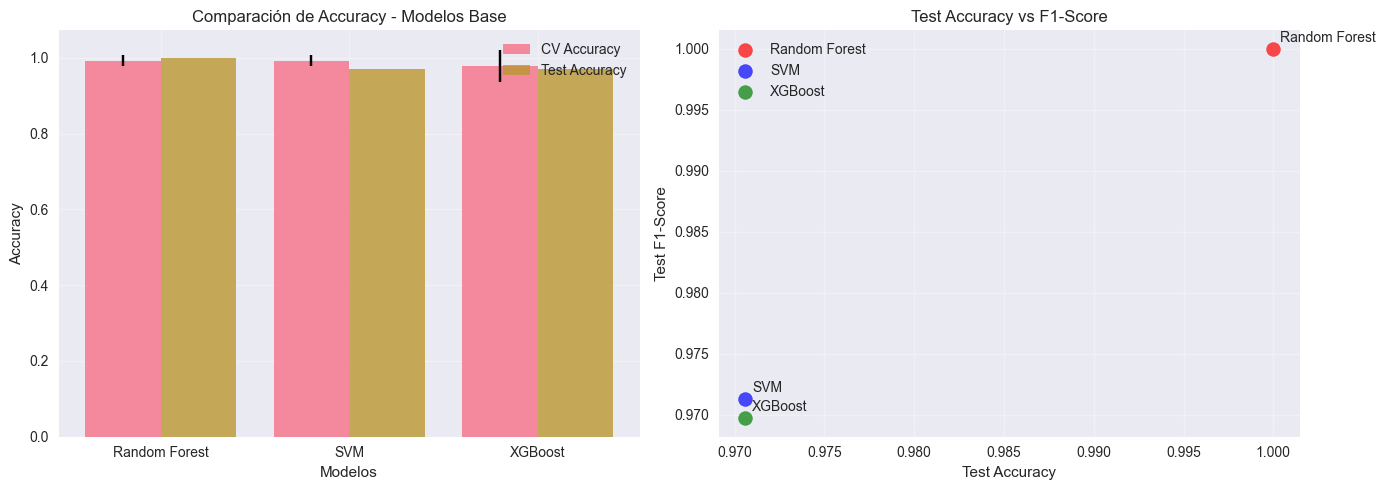

In [37]:
# Entrenamiento de modelos base
print("\n🤖 ENTRENAMIENTO DE MODELOS BASE")
print("="*40)

# Definir modelos con parámetros base
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf',
        random_state=42,
        probability=True  # Para obtener probabilidades
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss'
    )
}

# Almacenar resultados
model_results = {}
trained_models = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    print(f"\n🔄 Entrenando {model_name}...")
    
    # Validación cruzada
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=cv_strategy, 
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Entrenar en todo el conjunto de entrenamiento
    model.fit(X_train_scaled, y_train)
    
    # Predicciones en conjunto de prueba
    y_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Guardar resultados
    model_results[model_name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'predictions': y_pred
    }
    
    trained_models[model_name] = model
    
    print(f"   ✅ {model_name} completado")
    print(f"      CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"      Test Accuracy: {test_accuracy:.4f}")
    print(f"      Test F1-Score: {test_f1:.4f}")

# Resumen de resultados
print(f"\n📊 RESUMEN DE MODELOS BASE")
print("="*35)

results_df = pd.DataFrame({
    'Modelo': model_results.keys(),
    'CV_Accuracy_Mean': [results['cv_mean'] for results in model_results.values()],
    'CV_Accuracy_Std': [results['cv_std'] for results in model_results.values()],
    'Test_Accuracy': [results['test_accuracy'] for results in model_results.values()],
    'Test_F1_Score': [results['test_f1'] for results in model_results.values()]
})

display(results_df)

# Identificar mejor modelo base
best_model_name = results_df.loc[results_df['Test_Accuracy'].idxmax(), 'Modelo']
best_score = results_df.loc[results_df['Test_Accuracy'].idxmax(), 'Test_Accuracy']

print(f"\n🏆 Mejor modelo base: {best_model_name}")
print(f"   📈 Test Accuracy: {best_score:.4f}")

# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Comparación de accuracy
model_names = list(model_results.keys())
cv_means = [model_results[name]['cv_mean'] for name in model_names]
cv_stds = [model_results[name]['cv_std'] for name in model_names]
test_accs = [model_results[name]['test_accuracy'] for name in model_names]

x_pos = np.arange(len(model_names))
axes[0].bar(x_pos - 0.2, cv_means, 0.4, label='CV Accuracy', alpha=0.8, yerr=cv_stds)
axes[0].bar(x_pos + 0.2, test_accs, 0.4, label='Test Accuracy', alpha=0.8)
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Comparación de Accuracy - Modelos Base')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: F1-Score vs Accuracy
test_f1s = [model_results[name]['test_f1'] for name in model_names]
colors = ['red', 'blue', 'green']

for i, (name, acc, f1) in enumerate(zip(model_names, test_accs, test_f1s)):
    axes[1].scatter(acc, f1, s=100, c=colors[i], label=name, alpha=0.7)
    axes[1].annotate(name, (acc, f1), xytext=(5, 5), textcoords='offset points')

axes[1].set_xlabel('Test Accuracy')
axes[1].set_ylabel('Test F1-Score')
axes[1].set_title('Test Accuracy vs F1-Score')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS

🔄 Optimizando Random Forest...
   ✅ Random Forest optimizado
      Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
      CV Score: 1.0000
      Test Accuracy: 1.0000
      Mejora: +0.0000

🔄 Optimizando SVM...
   ✅ SVM optimizado
      Mejores parámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
      CV Score: 0.9926
      Test Accuracy: 0.9706
      Mejora: +0.0000

🔄 Optimizando XGBoost...
   ✅ XGBoost optimizado
      Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
      CV Score: 0.9854
      Test Accuracy: 0.9706
      Mejora: +0.0000

📊 COMPARACIÓN: BASE vs OPTIMIZADO


,Modelo,Base_Accuracy,Optimizado_Accuracy,Mejora,Base_F1,Optimizado_F1
0,Random Forest,1.000000,1.000000,0.0,1.000000,1.000000
1,SVM,0.970588,0.970588,0.0,0.971291,0.971291
2,XGBoost,0.970588,0.970588,0.0,0.969724,0.969724



🏆 MEJOR MODELO OPTIMIZADO: Random Forest
   📈 Test Accuracy: 1.0000
   🔧 Parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


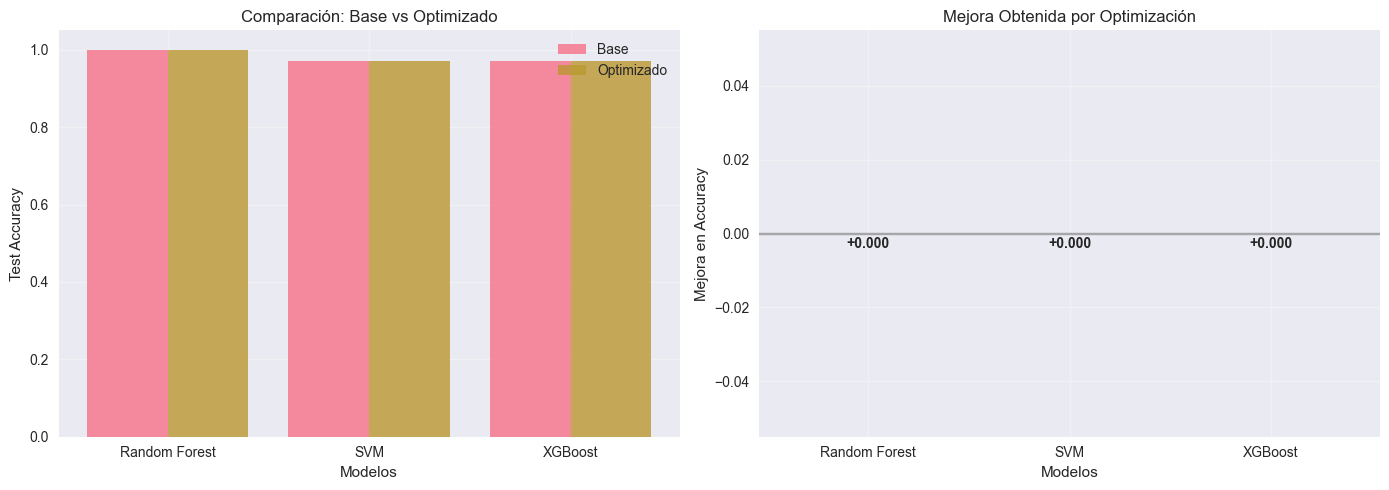

In [38]:
# Optimización de hiperparámetros
print("🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*40)

# Definir grids de parámetros para cada modelo
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'poly']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
}

# Almacenar modelos optimizados
optimized_models = {}
optimization_results = {}

# Optimizar cada modelo
for model_name in models.keys():
    print(f"\n🔄 Optimizando {model_name}...")
    
    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=models[model_name],
        param_grid=param_grids[model_name],
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    # Realizar búsqueda
    grid_search.fit(X_train_scaled, y_train)
    
    # Obtener mejor modelo
    best_model = grid_search.best_estimator_
    
    # Evaluar en conjunto de prueba
    y_pred_optimized = best_model.predict(X_test_scaled)
    test_accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
    test_f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')
    
    # Guardar resultados
    optimized_models[model_name] = best_model
    optimization_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'test_accuracy': test_accuracy_optimized,
        'test_f1': test_f1_optimized,
        'improvement_accuracy': test_accuracy_optimized - model_results[model_name]['test_accuracy'],
        'predictions': y_pred_optimized
    }
    
    print(f"   ✅ {model_name} optimizado")
    print(f"      Mejores parámetros: {grid_search.best_params_}")
    print(f"      CV Score: {grid_search.best_score_:.4f}")
    print(f"      Test Accuracy: {test_accuracy_optimized:.4f}")
    print(f"      Mejora: {optimization_results[model_name]['improvement_accuracy']:+.4f}")

# Crear tabla comparativa
print(f"\n📊 COMPARACIÓN: BASE vs OPTIMIZADO")
print("="*45)

comparison_data = []
for model_name in models.keys():
    comparison_data.append({
        'Modelo': model_name,
        'Base_Accuracy': model_results[model_name]['test_accuracy'],
        'Optimizado_Accuracy': optimization_results[model_name]['test_accuracy'],
        'Mejora': optimization_results[model_name]['improvement_accuracy'],
        'Base_F1': model_results[model_name]['test_f1'],
        'Optimizado_F1': optimization_results[model_name]['test_f1']
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Identificar mejor modelo optimizado
best_optimized_model = max(optimization_results.keys(), 
                          key=lambda x: optimization_results[x]['test_accuracy'])
best_optimized_score = optimization_results[best_optimized_model]['test_accuracy']

print(f"\n🏆 MEJOR MODELO OPTIMIZADO: {best_optimized_model}")
print(f"   📈 Test Accuracy: {best_optimized_score:.4f}")
print(f"   🔧 Parámetros: {optimization_results[best_optimized_model]['best_params']}")

# Visualización de mejoras
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Accuracy antes y después
model_names = list(models.keys())
base_accs = [model_results[name]['test_accuracy'] for name in model_names]
opt_accs = [optimization_results[name]['test_accuracy'] for name in model_names]

x_pos = np.arange(len(model_names))
axes[0].bar(x_pos - 0.2, base_accs, 0.4, label='Base', alpha=0.8)
axes[0].bar(x_pos + 0.2, opt_accs, 0.4, label='Optimizado', alpha=0.8)
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Comparación: Base vs Optimizado')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Mejoras obtenidas
improvements = [optimization_results[name]['improvement_accuracy'] for name in model_names]
colors = ['green' if imp > 0 else 'red' for imp in improvements]

axes[1].bar(model_names, improvements, color=colors, alpha=0.7)
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Mejora en Accuracy')
axes[1].set_title('Mejora Obtenida por Optimización')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].grid(alpha=0.3)

# Agregar valores en las barras
for i, imp in enumerate(improvements):
    axes[1].text(i, imp + (0.001 if imp > 0 else -0.001), f'{imp:+.3f}', 
                ha='center', va='bottom' if imp > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()


📈 EVALUACIÓN DETALLADA DEL MEJOR MODELO
🏆 Modelo seleccionado: Random Forest
📊 Accuracy final: 1.0000

📋 REPORTE DE CLASIFICACIÓN


,precision,recall,f1-score,support
girar,1.0,1.0,1.0,27.0
sentar,1.0,1.0,1.0,7.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,34.0
weighted avg,1.0,1.0,1.0,34.0



🔍 MATRIZ DE CONFUSIÓN


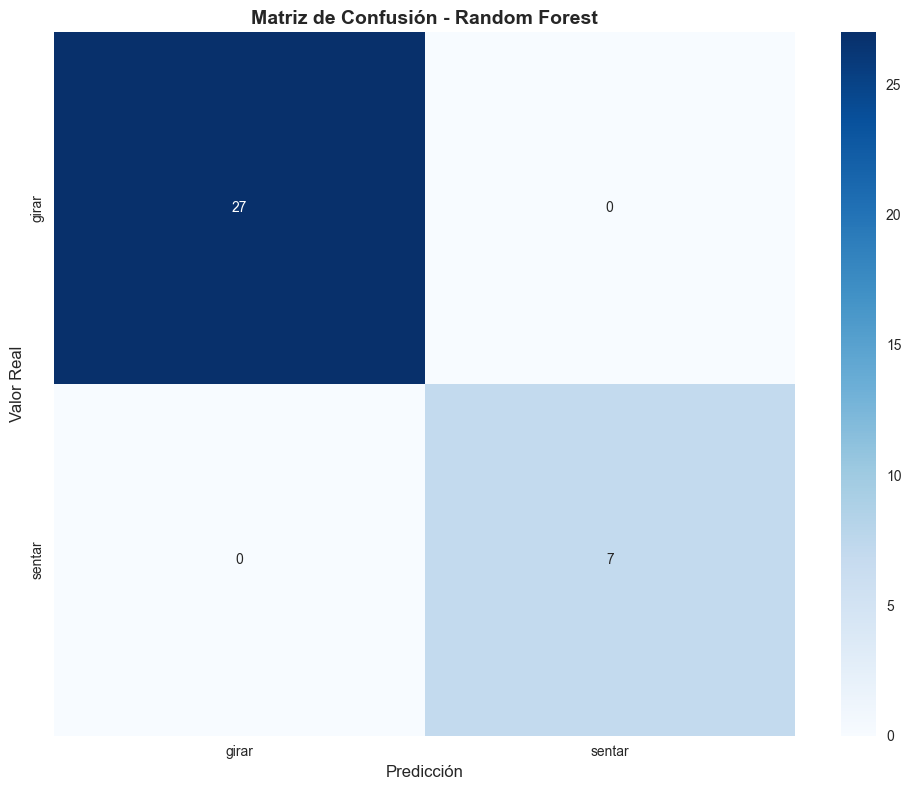


📊 ANÁLISIS POR CLASE

GIRAR:
   • Precisión: 1.0000
   • Recall: 1.0000
   • F1-Score: 1.0000
   • Support: 27 muestras
   • Verdaderos Positivos: 27
   • Falsos Positivos: 0
   • Falsos Negativos: 0

SENTAR:
   • Precisión: 1.0000
   • Recall: 1.0000
   • F1-Score: 1.0000
   • Support: 7 muestras
   • Verdaderos Positivos: 7
   • Falsos Positivos: 0
   • Falsos Negativos: 0

🎯 IMPORTANCIA DE CARACTERÍSTICAS
Top 10 características más importantes:
    1. 📍 y_23: 0.1967
    2. 📍 y_25: 0.1912
    3. 📍 vis_27: 0.1283
    4. 📐 angle_leg_left: 0.0831
    5. 📍 y_27: 0.0723
    6. 📏 dist_right_leg: 0.0609
    7. 📍 x_27: 0.0593
    8. 📍 vis_28: 0.0531
    9. 📍 y_28: 0.0527
   10. 📍 y_0: 0.0419


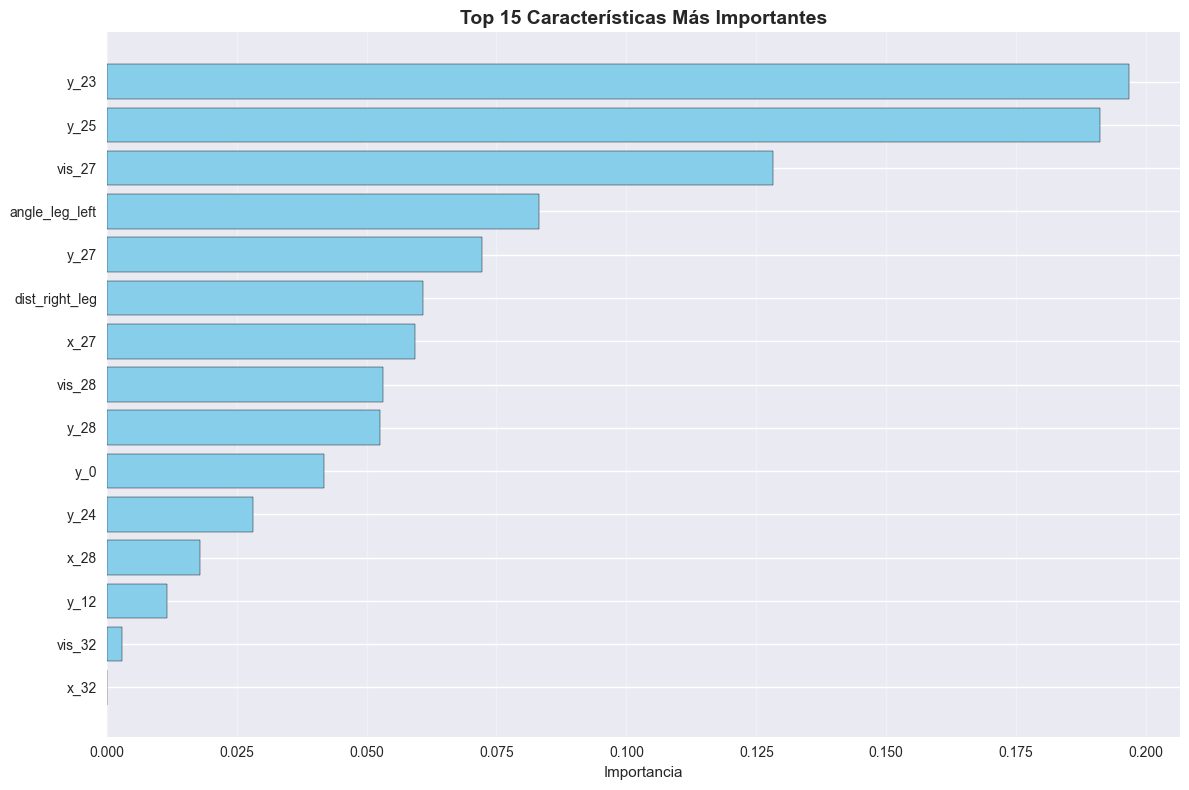


📈 CURVA DE APRENDIZAJE


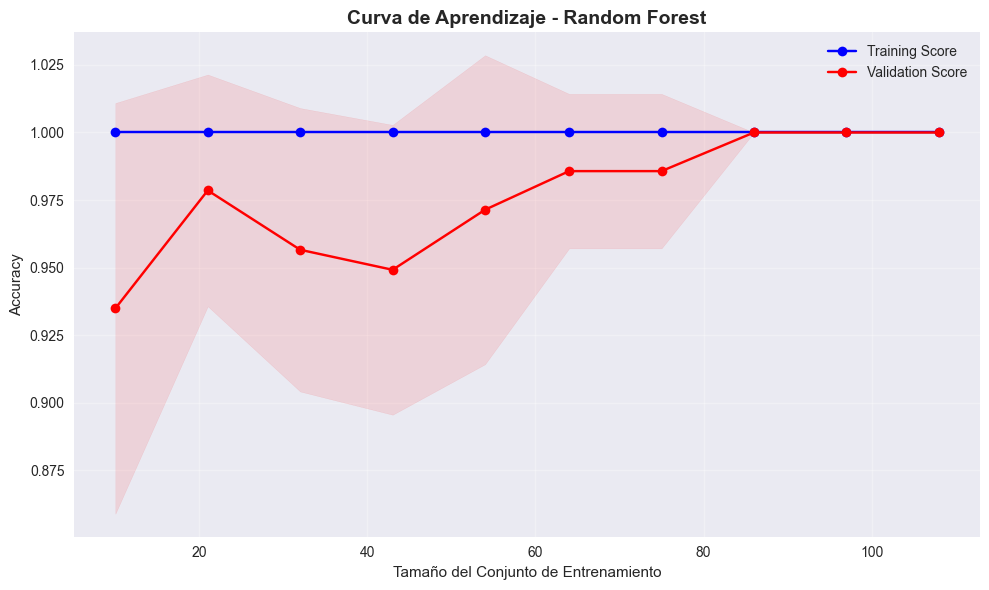

Convergencia del modelo: ✅ Buena


In [39]:
# Evaluación detallada del mejor modelo
print("📈 EVALUACIÓN DETALLADA DEL MEJOR MODELO")
print("="*45)

# Obtener el mejor modelo
final_model = optimized_models[best_optimized_model]
final_predictions = optimization_results[best_optimized_model]['predictions']

print(f"🏆 Modelo seleccionado: {best_optimized_model}")
print(f"📊 Accuracy final: {best_optimized_score:.4f}")

# Reporte de clasificación detallado
print(f"\n📋 REPORTE DE CLASIFICACIÓN")
print("="*35)

class_report = classification_report(
    y_test, final_predictions, 
    target_names=label_encoder.classes_,
    output_dict=True
)

# Mostrar reporte en formato tabla
report_df = pd.DataFrame(class_report).transpose()
display(report_df.round(4))

# Matriz de confusión
print(f"\n🔍 MATRIZ DE CONFUSIÓN")
print("="*25)

conf_matrix = confusion_matrix(y_test, final_predictions)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, 
           annot=True, 
           fmt='d', 
           cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title(f'Matriz de Confusión - {best_optimized_model}', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# Análisis por clase
print(f"\n📊 ANÁLISIS POR CLASE")
print("="*25)

for i, class_name in enumerate(label_encoder.classes_):
    precision = class_report[class_name]['precision']
    recall = class_report[class_name]['recall']
    f1 = class_report[class_name]['f1-score']
    support = int(class_report[class_name]['support'])
    
    print(f"\n{class_name.upper()}:")
    print(f"   • Precisión: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • Support: {support} muestras")
    
    # Calcular errores específicos
    true_positives = conf_matrix[i, i]
    false_positives = conf_matrix[:, i].sum() - true_positives
    false_negatives = conf_matrix[i, :].sum() - true_positives
    
    print(f"   • Verdaderos Positivos: {true_positives}")
    print(f"   • Falsos Positivos: {false_positives}")
    print(f"   • Falsos Negativos: {false_negatives}")

# Importancia de características (si el modelo lo soporta)
if hasattr(final_model, 'feature_importances_'):
    print(f"\n🎯 IMPORTANCIA DE CARACTERÍSTICAS")
    print("="*35)
    
    feature_importance_final = pd.DataFrame({
        'feature': final_features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 características más importantes:")
    for i, (_, row) in enumerate(feature_importance_final.head(10).iterrows()):
        feature_type = "📐" if row['feature'].startswith('angle_') else "📏" if row['feature'].startswith('dist_') else "📍"
        print(f"   {i+1:2d}. {feature_type} {row['feature']}: {row['importance']:.4f}")
    
    # Visualizar importancia de características
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_final.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia')
    plt.title('Top 15 Características Más Importantes', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Curva de aprendizaje
from sklearn.model_selection import learning_curve

print(f"\n📈 CURVA DE APRENDIZAJE")
print("="*25)

train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train_scaled, y_train,
    cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calcular medias y desviaciones estándar
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Score', color='red')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Accuracy')
plt.title(f'Curva de Aprendizaje - {best_optimized_model}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Convergencia del modelo: {'✅ Buena' if abs(train_mean[-1] - val_mean[-1]) < 0.05 else '⚠️ Posible overfitting'}")


In [40]:
# Crear directorio para modelos
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

print("💾 EXPORTACIÓN DEL MODELO FINAL")
print("="*35)

# Información del modelo a exportar
export_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_version = f"v1.0_{export_timestamp}"

print(f"🏆 Modelo seleccionado: {best_optimized_model}")
print(f"📊 Accuracy: {best_optimized_score:.4f}")
print(f"🏷️ Versión: {model_version}")

# 1. Exportar el modelo entrenado
model_filename = f"motion_classifier_{best_optimized_model.lower().replace(' ', '_')}_{model_version}.joblib"
model_path = models_dir / model_filename

joblib.dump(final_model, model_path)
print(f"✅ Modelo guardado: {model_path}")

# 2. Exportar el scaler
scaler_filename = f"scaler_{model_version}.joblib"
scaler_path = models_dir / scaler_filename

joblib.dump(scaler, scaler_path)
print(f"✅ Scaler guardado: {scaler_path}")

# 3. Exportar el label encoder
encoder_filename = f"label_encoder_{model_version}.joblib"
encoder_path = models_dir / encoder_filename

joblib.dump(label_encoder, encoder_path)
print(f"✅ Label encoder guardado: {encoder_path}")

# 4. Exportar el feature engineer
feature_engineer_filename = f"feature_engineer_{model_version}.joblib"
feature_engineer_path = models_dir / feature_engineer_filename

joblib.dump(fe, feature_engineer_path)
print(f"✅ Feature engineer guardado: {feature_engineer_path}")

# 5. Crear archivo de metadatos completo
metadata = {
    'model_info': {
        'name': best_optimized_model,
        'version': model_version,
        'timestamp': datetime.now().isoformat(),
        'accuracy': float(best_optimized_score),
        'framework': 'scikit-learn',
        'python_version': '3.8+',
        'dependencies': ['scikit-learn', 'xgboost', 'pandas', 'numpy']
    },
    'training_info': {
        'dataset_size': len(df_with_features),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'features_used': len(final_features),
        'classes': list(label_encoder.classes_),
        'class_distribution': {
            class_name: int(count) 
            for class_name, count in zip(label_encoder.classes_, 
                                       pd.Series(y_encoded).value_counts().sort_index())
        }
    },
    'model_parameters': optimization_results[best_optimized_model]['best_params'],
    'feature_info': {
        'selected_features': final_features,
        'feature_selection_method': 'SelectKBest + RandomForest Importance',
        'total_features_before_selection': len(feature_columns),
        'features_after_selection': len(final_features)
    },
    'performance_metrics': {
        'accuracy': float(best_optimized_score),
        'f1_score': float(optimization_results[best_optimized_model]['test_f1']),
        'cv_score': float(optimization_results[best_optimized_model]['best_cv_score']),
        'classification_report': class_report
    },
    'files': {
        'model': model_filename,
        'scaler': scaler_filename,
        'label_encoder': encoder_filename,
        'feature_engineer': feature_engineer_filename,
        'metadata': f"model_metadata_{model_version}.json"
    },
    'usage_instructions': {
        'loading': {
            'model': f"joblib.load('{model_filename}')",
            'scaler': f"joblib.load('{scaler_filename}')",
            'encoder': f"joblib.load('{encoder_filename}')",
            'feature_engineer': f"joblib.load('{feature_engineer_filename}')"
        },
        'prediction_pipeline': [
            "1. Cargar datos en formato: frame, landmark_index, x, y, z, visibility, movement",
            "2. Aplicar feature engineering con fe.pivot_landmarks(), fe.create_angle_features(), fe.create_distance_features()",
            "3. Seleccionar features finales usando metadata['feature_info']['selected_features']",
            "4. Escalar features con scaler.transform()",
            "5. Predecir con model.predict()",
            "6. Decodificar labels con label_encoder.inverse_transform()"
        ]
    }
}

# Guardar metadatos
metadata_filename = f"model_metadata_{model_version}.json"
metadata_path = models_dir / metadata_filename

with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)

print(f"✅ Metadatos guardados: {metadata_path}")

# 6. Crear script de predicción ejemplo
prediction_script = f'''#!/usr/bin/env python3
"""
Script de predicción para el Clasificador de Movimientos Corporales
Modelo: {best_optimized_model} - Versión: {model_version}
Accuracy: {best_optimized_score:.4f}

Uso:
    python predict_movement.py --input video_landmarks.csv
"""

import joblib
import pandas as pd
import numpy as np
import argparse
from pathlib import Path

class MovementPredictor:
    def __init__(self, models_dir="models"):
        """Inicializar el predictor cargando todos los componentes"""
        self.models_dir = Path(models_dir)
        
        # Cargar componentes
        self.model = joblib.load(self.models_dir / "{model_filename}")
        self.scaler = joblib.load(self.models_dir / "{scaler_filename}")
        self.label_encoder = joblib.load(self.models_dir / "{encoder_filename}")
        self.feature_engineer = joblib.load(self.models_dir / "{feature_engineer_filename}")
        
        # Cargar metadatos
        with open(self.models_dir / "{metadata_filename}", 'r') as f:
            import json
            self.metadata = json.load(f)
        
        self.selected_features = self.metadata['feature_info']['selected_features']
        
    def predict(self, landmarks_df):
        """
        Predecir movimiento a partir de landmarks
        
        Args:
            landmarks_df: DataFrame con columnas [frame, landmark_index, x, y, z, visibility, movement]
                         (movement puede ser dummy para predicción)
        
        Returns:
            list: Predicciones de movimientos
        """
        # 1. Feature engineering
        df_pivot = self.feature_engineer.pivot_landmarks(landmarks_df)
        df_with_angles = self.feature_engineer.create_angle_features(df_pivot)
        df_with_features = self.feature_engineer.create_distance_features(df_with_angles)
        
        # 2. Seleccionar features
        X = df_with_features[self.selected_features]
        
        # 3. Escalar
        X_scaled = self.scaler.transform(X)
        
        # 4. Predecir
        y_pred_encoded = self.model.predict(X_scaled)
        
        # 5. Decodificar
        predictions = self.label_encoder.inverse_transform(y_pred_encoded)
        
        return predictions
    
    def predict_proba(self, landmarks_df):
        """Obtener probabilidades de predicción"""
        # Similar al método predict pero retorna probabilidades
        df_pivot = self.feature_engineer.pivot_landmarks(landmarks_df)
        df_with_angles = self.feature_engineer.create_angle_features(df_pivot)
        df_with_features = self.feature_engineer.create_distance_features(df_with_angles)
        
        X = df_with_features[self.selected_features]
        X_scaled = self.scaler.transform(X)
        
        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(X_scaled)
            return probabilities, self.label_encoder.classes_
        else:
            raise ValueError("El modelo no soporta predicción de probabilidades")

def main():
    parser = argparse.ArgumentParser(description='Predictor de Movimientos Corporales')
    parser.add_argument('--input', required=True, help='Archivo CSV con landmarks')
    parser.add_argument('--output', help='Archivo de salida (opcional)')
    
    args = parser.parse_args()
    
    # Cargar predictor
    predictor = MovementPredictor()
    
    # Cargar datos
    df = pd.read_csv(args.input)
    
    # Predecir
    predictions = predictor.predict(df)
    
    # Mostrar resultados
    print(f"Predicciones realizadas: {{len(predictions)}}")
    for i, pred in enumerate(predictions):
        print(f"Frame {{i}}: {{pred}}")
    
    # Guardar si se especifica archivo de salida
    if args.output:
        results_df = pd.DataFrame({{'frame': range(len(predictions)), 'predicted_movement': predictions}})
        results_df.to_csv(args.output, index=False)
        print(f"Resultados guardados en: {{args.output}}")

if __name__ == "__main__":
    main()
'''

script_path = models_dir / f"predict_movement_{model_version}.py"
with open(script_path, 'w', encoding='utf-8') as f:
    f.write(prediction_script)

print(f"✅ Script de predicción creado: {script_path}")

# 7. Crear README para el modelo
readme_content = f'''# Clasificador de Movimientos Corporales

**Modelo:** {best_optimized_model}  
**Versión:** {model_version}  
**Accuracy:** {best_optimized_score:.4f}  
**Fecha:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Descripción

Este modelo clasifica 5 tipos de movimientos corporales basándose en landmarks de pose extraídos con MediaPipe:
- Girar
- Sentar  
- Parar
- Ir al frente
- Devolverse

## Archivos del Modelo

- `{model_filename}` - Modelo entrenado
- `{scaler_filename}` - Escalador de características  
- `{encoder_filename}` - Codificador de etiquetas
- `{feature_engineer_filename}` - Ingeniero de características
- `{metadata_filename}` - Metadatos completos
- `predict_movement_{model_version}.py` - Script de predicción

## Uso Rápido

```python
import joblib
import pandas as pd

# Cargar componentes
model = joblib.load("{model_filename}")
scaler = joblib.load("{scaler_filename}")
encoder = joblib.load("{encoder_filename}")
fe = joblib.load("{feature_engineer_filename}")

# Cargar datos (formato: frame, landmark_index, x, y, z, visibility, movement)
df = pd.read_csv("your_data.csv")

# Pipeline de predicción
df_pivot = fe.pivot_landmarks(df)
df_angles = fe.create_angle_features(df_pivot)
df_features = fe.create_distance_features(df_angles)

# Seleccionar features (ver metadatos para lista completa)
selected_features = {final_features}
X = df_features[selected_features]

# Escalar y predecir
X_scaled = scaler.transform(X)
predictions_encoded = model.predict(X_scaled)
predictions = encoder.inverse_transform(predictions_encoded)
```

## Características del Modelo

- **Algoritmo:** {best_optimized_model}
- **Features:** {len(final_features)} características seleccionadas
- **Datos de entrenamiento:** {len(X_train):,} muestras
- **Validación cruzada:** {optimization_results[best_optimized_model]['best_cv_score']:.4f}
- **F1-Score:** {optimization_results[best_optimized_model]['test_f1']:.4f}

## Instalación de Dependencias

```bash
pip install scikit-learn xgboost pandas numpy joblib
```

## Soporte

Para preguntas sobre el uso del modelo, consulta los metadatos en `{metadata_filename}`.
'''

readme_path = models_dir / f"README_{model_version}.md"
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)

print(f"✅ README creado: {readme_path}")

# Resumen final
print(f"\n🎉 EXPORTACIÓN COMPLETADA")
print("="*30)
print(f"📁 Directorio: {models_dir}/")
print(f"🏆 Modelo: {best_optimized_model}")
print(f"📊 Accuracy: {best_optimized_score:.4f}")
print(f"🏷️ Versión: {model_version}")
print(f"\n📦 Archivos exportados:")
print(f"   • Modelo: {model_filename}")
print(f"   • Scaler: {scaler_filename}")  
print(f"   • Encoder: {encoder_filename}")
print(f"   • Feature Engineer: {feature_engineer_filename}")
print(f"   • Metadatos: {metadata_filename}")
print(f"   • Script predicción: predict_movement_{model_version}.py")
print(f"   • README: README_{model_version}.md")

print(f"\n🚀 El modelo está listo para usar en Streamlit/Flask!")
print(f"💡 Usa el script predict_movement_{model_version}.py como base para tu aplicación web.")


💾 EXPORTACIÓN DEL MODELO FINAL
🏆 Modelo seleccionado: Random Forest
📊 Accuracy: 1.0000
🏷️ Versión: v1.0_20250605_180729
✅ Modelo guardado: models\motion_classifier_random_forest_v1.0_20250605_180729.joblib
✅ Scaler guardado: models\scaler_v1.0_20250605_180729.joblib
✅ Label encoder guardado: models\label_encoder_v1.0_20250605_180729.joblib
✅ Feature engineer guardado: models\feature_engineer_v1.0_20250605_180729.joblib
✅ Metadatos guardados: models\model_metadata_v1.0_20250605_180729.json
✅ Script de predicción creado: models\predict_movement_v1.0_20250605_180729.py
✅ README creado: models\README_v1.0_20250605_180729.md

🎉 EXPORTACIÓN COMPLETADA
📁 Directorio: models/
🏆 Modelo: Random Forest
📊 Accuracy: 1.0000
🏷️ Versión: v1.0_20250605_180729

📦 Archivos exportados:
   • Modelo: motion_classifier_random_forest_v1.0_20250605_180729.joblib
   • Scaler: scaler_v1.0_20250605_180729.joblib
   • Encoder: label_encoder_v1.0_20250605_180729.joblib
   • Feature Engineer: feature_engineer_v1.0_20